# **End-to-end MNIST classifier** 🔢

## **Installation** 

- Install Docker and Conda.
- sudo usermod -aG docker "$USER" (on Linux)
- conda create -n scanflow python=3.6
- source activate scanflow
- git clone https://github.com/gusseppe/scanflow
- cd scanflow
- pip install -r requirements.txt

**In the future**

> Install Docker and Conda.

> pip install scanflow

## **Run scanflow server** 

It starts the **Scanflow UI** (dashboard) and **Scanflow API** (REST):

- python cli.py server

Then go to:

- http://localhost:8050

Note: By default server_port = 8050.

Use python cli.py --help for more information.

## **Steps**

- **Training**: Define the training executor using Pytorch and the MNIST data.
- **Inference**: Define the inference executor to make predictions using a trained model.
    - **Agents**: Define the Tracker, Checker, Improver and Planner agent.
- **Detector training**: Define a detector training executor that will be trained on x_train. Built-in Scanflow executor (from submitted paper).
- **Detector Inference**: Define a detector inference executor for both detect anomalies and pick a subset of them for retraining. It will be used by the Checker agent. Built-in Scanflow executor (from submitted paper).(https://colab.research.google.com/drive/1t0EgpPk5_mEMNb_AvN7yJ_Tz88bqgS9A). 
- **Retraining**: Define a retraining executor to retrain the model using x_train + x_chosen. It will be used by the Improver agent. Built-in Scanflow executor.
- **Labeling**: Define a labeling executor to label the x_chosen artifact (Future work). 
- **Dashboard**: Call the inference executor from a web application.

# **Definition and Deployment** 📑

## Model (training)

Let's get some MNIST data to train a CNN-based model.

In [3]:
import utils
x_train_sample, y_train_sample = utils.sample_train_mnist()
x_train_sample.shape

(1000, 28, 28)

We load only 1k instances (from the original 60k) to make the training faster hence the accuracy will be lower as well.

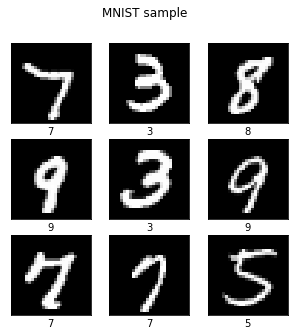

In [4]:
utils.show_numbers(x_train_sample, y_train_sample, title=f"MNIST sample")

Here we start the training executor definition. We need the following things:

**Input**
- Python script: training.py
- Parameters for the script: model_name, x_train_path, y_train_path, etc.
- requirements: req_training.txt, the required libraries to build the training image.

**Output**
- The input dataset for both training and testing (x_train, x_test, ...) will be saved in Tracker Repository (MLflow) to have a data version control.
- Model (mnist_cnn) and version (1,2,3 and on) will be saved and registered in the Tracker Repository. It will save the artifacts (serialized model) and register the model in the Model Registry.

Eventually, the data scientist will select a model version (from the Model Registry) and tag it as a "Production" Model. So that, this model will be use in the Inference stage.

In [1]:
import matplotlib.pyplot as plt
import os
import sys

sys.path.insert(1,'../..')
from scanflow.setup import Setup, Executor, Workflow
from scanflow.special import Tracker
from scanflow.deploy import Deploy

# workflow folder that contains all the scripts
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")

# We can define a list of executors. In this case, we only have one executor.
executors = [Executor(name='training', 
                      file='training.py',
                      parameters={'model_name': 'mnist_cnn',
                                  
                                  'x_train_path': './mnist_sample/train_images.npy', 
                                  'y_train_path': './mnist_sample/train_labels.npy',
                                  
                                  'x_test_path': './mnist/test_images.npy',
                                  'y_test_path': './mnist/test_labels.npy'},
                      requirements='req_training.txt')           
            ]

# A workflow contains a list of executors and also special nodes. 
# In this case, we have only one offline special node: Tracker MLflow.
workflow1 = Workflow(name='training-mnist', 
                     executors=executors,
                     tracker=Tracker(mode='offline')) # No agents involved
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

27-Apr-21 00:17:10 -  INFO - [Tracker] Port 8002 is in use by Tracker.



Setup = (
    Workflows: ['training-mnist']
)

All the experiments will be saved at MLflow UI: http://localhost:8002 (Tracker repository). It contains also the Model registry (where all the model versions are registered).

Once we have defined the training executor we can then build the corresponding images and start the workflow.

In [2]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows(True)

  0%|          | 0/1 [00:00<?, ?it/s]27-Apr-21 00:17:13 -  INFO - [++] Starting workflow: [training-mnist].
27-Apr-21 00:17:13 -  INFO - [+] Starting env: [training-mnist:training].
27-Apr-21 00:17:13 -  WARNING - [+] Environment: [training-mnist-training] is already running.
27-Apr-21 00:17:13 -  INFO - [+] Starting image: [tracker-mlflow.
27-Apr-21 00:17:13 -  WARNING - [+] Environment: [tracker-mlflow] is already running.
27-Apr-21 00:17:13 -  INFO - [+] Loading [containers_alive.json].
27-Apr-21 00:17:13 -  INFO - [-] Creating new [containers_alive.json].
27-Apr-21 00:17:13 -  INFO - [Tracker]  'Scanflow' experiment loaded.
27-Apr-21 00:17:14 -  INFO - [+] Workflow: [training-mnist] was started successfully.
100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Now we have a Docker container of name: {workflow-name}-{executor-name} running on the computer.

Then, we run the workflow to execute the script (in our case, training.py) inside the new created container. It performs the model training and then save a model version on Model Registry.


In [3]:
deployer.run_workflows(verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]26-Apr-21 23:15:23 -  INFO - [++] Running workflow: [training-mnist].
26-Apr-21 23:15:23 -  INFO - [+] Running env: [training-mnist:training].
26-Apr-21 23:15:40 -  INFO - [+] Running (training.py). 
26-Apr-21 23:15:40 -  INFO - [+] Output:  Train Epoch: 1 [0/1000 (0%)]	Loss: 2.299094
Registered model 'mnist_cnn' already exists. Creating a new version of this model...
2021/04/26 21:15:40 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: mnist_cnn, version 3
Created version '3' of model 'mnist_cnn'.
 
26-Apr-21 23:15:40 -  INFO - [+] Environment (training-mnist-training) finished successfully. 
26-Apr-21 23:15:40 -  INFO - [+] Workflow: [training-mnist] was run successfully.
100%|██████████| 1/1 [00:17<00:00, 17.46s/it]
26-Apr-21 23:15:40 -  INFO - [+] Elapsed time: 17.46 seconds


In [10]:
# Of course you can stop the workflows, it will stop and prune all the created containers.
# deployer.stop_workflows()

## Model (inference)



Similar to the training part, we define the inference executor. We need the following:

- Python script: inference-batch.py
- Parameters for the script: x_inference_path, model_name and model_version.
- requirements: req_inference_batch.txt, the required libraries to build the inference image.

Apart from the inference executor we also define the special agents:
- **Tracker**: the one in charge of linking the multi agent system to the outside. For instance, it can get the x_inference and feed to the Checker agent.
- **Checker**: this agent calls the detector to get the anomalies and the chosen instances to be considered for the retraining. The Checker's output is the feedback.
- **Improver**: it decides what to do with the feedback. For instance, if n_anomalies > threshold, then perform a retraining with x_train + x_chosen.
- **Planner**: this agent receives the order from the Improver to make some changes in the original workflow. For instance, change the current "Production" model by the new created model from the Improver.

In [3]:
import sys
import numpy as np
import os
sys.path.insert(1,'../..')

from scanflow.setup import Setup, Executor, Workflow
from scanflow.special import Tracker, Checker, Improver, Planner, Predictor
from scanflow.deploy import Deploy

# workflow folder that contains all the scripts
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")

# This executor can receive any mnist model name and version (from Model Registry).
# This inference is of type "batch", meaning that the inference 
# is done by a python script (predict) and not an API (REST).

executors = [Executor(name='inference-batch', 
                      file='inference-batch.py',
                      parameters={'model_name':'mnist_cnn', 'model_version':1},
                      requirements='req_inference_batch.txt')           
            ]

# 
workflow1 = Workflow(name='inference-mnist', 
                     executors=executors,
                     tracker=Tracker(mode='online'),
                     checker=Checker(mode='online'),
                     improver=Improver(mode='online'),
                     planner=Planner(mode='online'))
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

27-Apr-21 00:18:11 -  INFO - [Tracker] Port 8002 is in use by Tracker.
27-Apr-21 00:18:11 -  INFO - [Checker] Port 8004 is set successfully.
27-Apr-21 00:18:11 -  INFO - [Improver] Port 8006 is in use by Improver.
27-Apr-21 00:18:11 -  INFO - [Planner] Port 8007 is in use by Planner.



Setup = (
    Workflows: ['inference-mnist']
)

In [4]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows(True)
# deployer.pipeline() # Build, Start and Run all together

  0%|          | 0/1 [00:00<?, ?it/s]27-Apr-21 00:18:13 -  INFO - [++] Starting workflow: [inference-mnist].
27-Apr-21 00:18:13 -  INFO - [+] Starting env: [inference-mnist:inference-batch].
27-Apr-21 00:18:13 -  WARNING - [+] Environment: [inference-mnist-inference-batch] is already running.
27-Apr-21 00:18:13 -  INFO - [+] Starting image: [tracker-mlflow.
27-Apr-21 00:18:13 -  WARNING - [+] Environment: [tracker-mlflow] is already running.
27-Apr-21 00:18:13 -  WARNING - [+] Environment: [inference-mnist-tracker-agent] is already running.
27-Apr-21 00:18:13 -  WARNING - [+] Environment: [inference-mnist-checker-agent] is already running.
27-Apr-21 00:18:13 -  WARNING - [+] Environment: [inference-mnist-improver-agent] is already running.
27-Apr-21 00:18:13 -  WARNING - [+] Environment: [inference-mnist-planner-agent] is already running.
27-Apr-21 00:18:13 -  INFO - [+] Loading [containers_alive.json].
27-Apr-21 00:18:13 -  INFO - [Tracker]  'Scanflow' experiment loaded.
27-Apr-21 00:

## Detector (training)

This executor trains the drift detector using the **x_train**. It should learn patterns in the original distribution to then detect if the **x_inference** follows a similar one.

In [5]:
import sys
import numpy as np
import os
sys.path.insert(0,'../..')

from scanflow.setup import Setup, Executor, Workflow
from scanflow.special import Tracker, Checker, Improver, Planner
from scanflow.deploy import Deploy

# workflow folder that contains all the scripts
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")

# This detector-batch comprises an anomaly detector and a picker
executors = [Executor(name='detector-training', 
                      file='detector-training.py',
                      parameters={'name': 'detector_mnist',
                                  'x_train_path': './mnist_sample/train_images.npy',
                                  },
                      requirements='req_detector.txt')           
            ]


workflow1 = Workflow(name='detector-training-mnist', 
                     executors=executors,
                     tracker=Tracker(mode='offline'))
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

27-Apr-21 00:18:56 -  INFO - [Tracker] Port 8002 is in use by Tracker.



Setup = (
    Workflows: ['detector-training-mnist']
)

In [6]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows(True)
# deployer.pipeline() # Build, Start and Run

  0%|          | 0/1 [00:00<?, ?it/s]27-Apr-21 00:18:58 -  INFO - [++] Starting workflow: [detector-training-mnist].
27-Apr-21 00:18:58 -  INFO - [+] Starting env: [detector-training-mnist:detector-training].
27-Apr-21 00:18:58 -  WARNING - [+] Environment: [detector-training-mnist-detector-training] is already running.
27-Apr-21 00:18:58 -  INFO - [+] Starting image: [tracker-mlflow.
27-Apr-21 00:18:58 -  WARNING - [+] Environment: [tracker-mlflow] is already running.
27-Apr-21 00:18:58 -  INFO - [+] Loading [containers_alive.json].
27-Apr-21 00:18:58 -  INFO - [Tracker]  'Scanflow' experiment loaded.
27-Apr-21 00:18:59 -  INFO - [+] Workflow: [detector-training-mnist] was started successfully.
100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


In [7]:
deployer.run_workflows(verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]27-Apr-21 00:00:44 -  INFO - [++] Running workflow: [detector-training-mnist].
27-Apr-21 00:00:44 -  INFO - [+] Running env: [detector-training-mnist:detector-training].
27-Apr-21 00:00:50 -  INFO - [+] Running (detector-training.py). 
27-Apr-21 00:00:50 -  INFO - [+] Output:  2021-04-26 22:00:45.680132: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-04-26 22:00:45.680344: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-04-26 22:00:47.872450: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-26 22:00:47.873164: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1:

In [13]:
# deployer.stop_workflows()

## Detector (inference)

This executor contains the detector (for inference) and the picker. This detector will be used by the Checker agent.

In [7]:
import sys
import numpy as np
import os
sys.path.insert(0,'../..')

from scanflow.setup import Setup, Executor, Workflow
from scanflow.special import Tracker, Checker, Improver, Planner
from scanflow.deploy import Deploy

# workflow folder that contains all the scripts
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")

# This detector-batch comprises an anomaly detector and a picker
# It requires the inference run_id from where to get the artifacts.
# Apart from the run_id it requires the artifact paths. 
# Both run_id and artifact paths can be changed dynamically.

executors = [Executor(name='detector-batch', 
                      file='detector-batch.py',
                      parameters={'run_id': 'inference_run_id', 
                                  'x_inference_artifact': 'x_inference.npy',
                                  'y_inference_artifact': 'y_inference.npy'
                                 },
                      requirements='req_detector.txt')           
            ]

workflow1 = Workflow(name='detector-inference-mnist', 
                     executors=executors,
                     tracker=Tracker(mode='offline'))
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

27-Apr-21 00:19:02 -  INFO - [Tracker] Port 8002 is in use by Tracker.



Setup = (
    Workflows: ['detector-inference-mnist']
)

In [8]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows(True)
# deployer.pipeline() # Build, Start and Run

  0%|          | 0/1 [00:00<?, ?it/s]27-Apr-21 00:19:04 -  INFO - [++] Starting workflow: [detector-inference-mnist].
27-Apr-21 00:19:04 -  INFO - [+] Starting env: [detector-inference-mnist:detector-batch].
27-Apr-21 00:19:04 -  WARNING - [+] Environment: [detector-inference-mnist-detector-batch] is already running.
27-Apr-21 00:19:04 -  INFO - [+] Starting image: [tracker-mlflow.
27-Apr-21 00:19:04 -  WARNING - [+] Environment: [tracker-mlflow] is already running.
27-Apr-21 00:19:04 -  INFO - [+] Loading [containers_alive.json].
27-Apr-21 00:19:04 -  INFO - [Tracker]  'Scanflow' experiment loaded.
27-Apr-21 00:19:05 -  INFO - [+] Workflow: [detector-inference-mnist] was started successfully.
100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


In [2]:
# deployer.stop_workflows()

In [58]:
# deployer.run_workflows(verbose=True)

## Retraining

This executor will be used by the Improver agent to retrain the model. So that, the new training dataset will be as follows:

**Without human intervention**

> x_new_train = x_train + x_chosen.

> y_new_train = y_train + y_predicted.

**With human intervention**

> x_new_train = x_train + x_chosen.

> y_new_train = y_train + y_human_labeled.

In [1]:
import sys
import matplotlib.pyplot as plt
import os
sys.path.insert(0,'../..')

from scanflow.setup import Setup, Executor, Workflow
from scanflow.special import Tracker
from scanflow.deploy import Deploy

# workflow folder that contains all the scripts
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")


executors = [Executor(name='retraining', 
                      file='retraining.py',
                      parameters={'model_name': 'mnist_cnn_retrained',
                                  'run_id': 'inference_run_id',
                                  'x_new_train_artifact': 'x_inference.npy', 
                                  'y_new_train_artifact': 'y_inference.npy',
                                  
                                  'x_test_path': './mnist/test_images.npy',
                                  'y_test_path': './mnist/test_labels.npy'},
                      env='training-mnist-training') #reuse modeling image         
            ]


workflow1 = Workflow(name='retraining-mnist', 
                     executors=executors,
                     tracker=Tracker(mode='offline'))
    
setup = Setup(app_dir, workflows=[workflow1],
                             verbose=True)

setup

27-Apr-21 01:06:51 -  INFO - [Tracker] Port 8002 is in use by Tracker.



Setup = (
    Workflows: ['retraining-mnist']
)

In [2]:
deployer = Deploy(setup)

deployer.build_workflows()
deployer.start_workflows()

100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


In [59]:
# deployer.run_workflows(verbose=True)

In [18]:
# deployer.stop_workflows()

## Labeling (Human agent)

It contains the Active learning step. Available soon

# **Productionizing** 🖥️

## App: Batch / Online

Now you can embed scanflow into your batch or online web application. For this example we will use gradio:

- pip install gradio
- python app-batch.py (or python app-online.py)

## Agent Trigger Reactivity

In [ ]:
import json

def trigger_mas():
    import requests

    url = 'http://localhost:8003/send/checker/anomaly'
    response = requests.get(
        url=url,
        headers={"accept": "application/json"})

    response_json = json.loads(response.text)
    print(response_json)
    
trigger_mas()

In [3]:
!curl -X 'GET' \
  'http://localhost:8003/send/checker/anomaly' \
  -H 'accept: application/json'

{"feedback":{"inference_run_id":"3480177f9e39448693609bc7cad79ea2","x_inference_artifact":"x_inference.npy","y_inference_artifact":"y_inference.npy","detector_run_id":"ef27df67e6044791833edbb98c87c3c1","x_chosen_artifact":"x_inference_chosen.npy","y_chosen_artifact":"x_inference_chosen.npy","x_new_train_artifact":"x_new_train.npy","y_new_train_artifact":"y_new_train.npy","n_anomalies":8,"percentage_anomalies":0.36363636363636365,"checker_agent_run_id":"633656f6f1ac4519909d6423d5e604f7"},"conclusions":{"action":"Retraining the model using the new augmented data=x_new_train.npy","reason":"current_metric=73.91 < new_metric=73.91","planner":{"Plan":{"order":"Transition","current_model_name":"mnist_cnn","current_model_version":"3","new_model_name":"mnist_cnn_new","new_model_version":"3","result":"Current model has been archived. New model is labeled as 'Production'"}}}}

# Remove all the metadata

It will remove artifacts, metrics, params and also registered models.

In [1]:
import pandas as pd
import os
import sys
sys.path.insert(0,'../..')

from scanflow import track

base_path = os.path.dirname(os.path.dirname(os.getcwd()))
app_dir = os.path.join(base_path, "examples/demo_mnist/")
tracker = track.Tracker(app_dir)
# last_artifacts = tracker.list_artifacts(workflow_name='mnist')
# print(last_artifacts.keys())


In [9]:
# tracker.delete_tracked_data()